In [28]:
# General Dependencies
import matplotlib.pyplot as plt
import numpy as np
import torch

# CIEMSS Specific
from pyciemss.PetriNetODE.interfaces import setup_model, reset_model, intervene, sample, calibrate, load_petri_model
from pyciemss.utils import get_tspan

In [71]:
### Plotting Utils ###
# rgb, cmy, k, mixes
COLORS=['r','g','b','magenta','gold','cyan','silver','grey','black']

def setup_ax():
    fig = plt.figure(facecolor='w', figsize=(6, 6))
    ax  = fig.add_subplot(111, axisbelow=True) # setup graph
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Number Infected')
    return ax

def plot_trajectories(sol, tspan, data=None, focus=None, title="", ax=None, colors=None):
    
    torch_tspan = torch.as_tensor(tspan) # for use in multi-trajectory graph
    indices = torch.ones_like(tspan).bool()
    var_list = [x for x in list(sol.keys()) if "_sol" in x] # skip beta, gamma, etc parameters
    if focus: var_list = [x for x in var_list if x[:-4] in focus]
    else: focus = var_list
    if True in list("+" in x for x in focus):      # an aggregate state exists
        var_list += [i for i in focus if "+" in i] # add as a variable
    data_keys = [list(x[1].keys())[0] for x in data] if data else [] # get trained variables
    
    for i,var in enumerate(var_list):
        if colors: c = colors[i]
        else: c = COLORS[i]
        
        if "+" in var: # aggregate of >1 states
            add_vars = var.split("+")
            var_sol  = sum([sol[i+"_sol"] for i in add_vars])
        else: var_sol = sol[var]
        
        if not ax: ax = setup_ax()
        if len(sol[list(sol.keys())[3]]) == 1: # single trajectory, draw line
            ax.plot(tspan, var_sol.squeeze().detach().numpy(), c, alpha=0.5, lw=3, label=var+title)
        
        else: # fill between multiple trajectories
            I_low = torch.quantile(var_sol, 0.05, dim=0).detach().numpy()
            I_hi  = torch.quantile(var_sol, 0.95, dim=0).detach().numpy()
            I_mid = (I_hi+I_low)/2
            ax.fill_between(torch_tspan[indices], I_low[indices], I_hi[indices],
                            alpha=0.2, color=c, label=var+title)
            ax.plot(tspan, I_mid, c, alpha=0.5, lw=3) # average value
        
        if var[:-4] in data_keys: # plot training points of this variable
            x = np.array([x[0] for x in data if var[:-4] in list(x[1].keys())])
            y = np.array([x[1][var[:-4]] for x in data if var[:-4] in list(x[1].keys())]) # without '_sol' suffix
            ax.scatter(x,y,label=var[:-4]+" data",color=c)
    ax.legend(loc='best')
    return ax

# Load MIRA Model

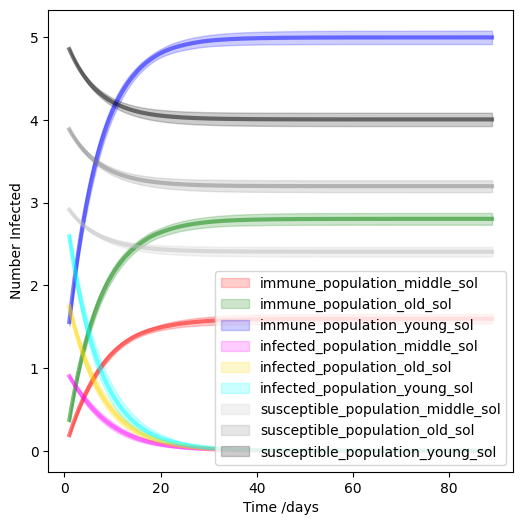

In [60]:
full_tspan = get_tspan(1, 89, 890) # amount of days we're simulating (89) and resolution (890 points)
filepath   = "../../test/models/evaluation_examples/scenario_1/scenario1_three_ages_mira.json"

# Fetch the MIRA model
mira_raw   = load_petri_model(filepath, add_uncertainty=True)

# Set the initial parameters
# These are chosen to visualize how the model is stratified
start_state = dict(
    susceptible_population_old   =4.0,
    infected_population_old      =2.0,
    immune_population_old        =0.0,
    
    susceptible_population_middle=3.0,
    infected_population_middle   =1.0,
    immune_population_middle     =0.0,
    
    susceptible_population_young =5.0,
    infected_population_young    =3.0,
    immune_population_young      =1.0
)
mira_model = setup_model(mira_raw, start_time=0, start_state=start_state)

# Simulate this fresh model and plot
solution = sample(mira_model, timepoints=full_tspan, num_samples=30)
plot_trajectories(solution,full_tspan)
plt.show()

In [73]:
mira_model.parameters

<bound method Module.parameters of ScaledBetaNoisePetriNetODESystem(
	beta_0 = Uniform(low: 0.09000000357627869, high: 0.10999999940395355),
	beta_1 = Uniform(low: 0.09000000357627869, high: 0.10999999940395355),
	beta_2 = Uniform(low: 0.09000000357627869, high: 0.10999999940395355),
	beta_3 = Uniform(low: 0.09000000357627869, high: 0.10999999940395355),
	beta_4 = Uniform(low: 0.09000000357627869, high: 0.10999999940395355),
	beta_5 = Uniform(low: 0.09000000357627869, high: 0.10999999940395355),
	beta_6 = Uniform(low: 0.09000000357627869, high: 0.10999999940395355),
	beta_7 = Uniform(low: 0.09000000357627869, high: 0.10999999940395355),
	beta_8 = Uniform(low: 0.09000000357627869, high: 0.10999999940395355),
	gamma_0 = Uniform(low: 0.18000000715255737, high: 0.2199999988079071),
	gamma_1 = Uniform(low: 0.18000000715255737, high: 0.2199999988079071),
	gamma_2 = Uniform(low: 0.18000000715255737, high: 0.2199999988079071),
	pseudocount = 1.0
)>

# Question 1.
**Subtask A** - Stratify by young, middle and old ages. Simulate with many configurations.

First, we set up all of the initial conditions and priors that are persistent across a.i, a.ii, etc.

Note that as we are applying a probabilistic approach, we interpret every statement of the form "assume the parameters are x" to mean "assume the prior over parameters are centered at x, with some user-specified distribution". 

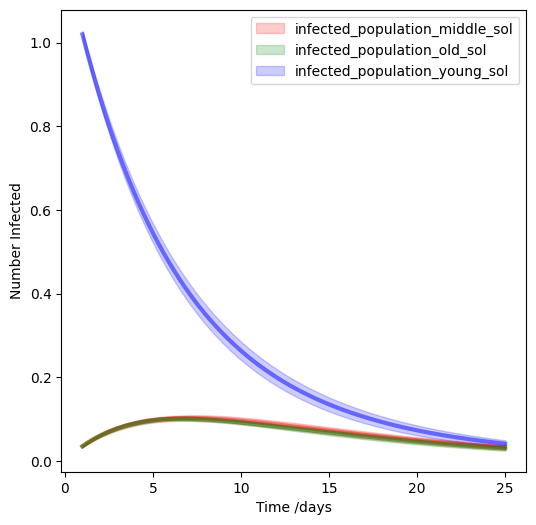

In [77]:
N = 6000 # population size

full_tspan = get_tspan(1, 25, 250) # amount of days we're simulating (25) and resolution (250 points)

# "young people have .02% infected (around 1 person) but the other ages are entirely susceptible"
start_state = dict(
    susceptible_population_old   =1.0,
    infected_population_old      =0.0,
    immune_population_old        =0.0,
    
    susceptible_population_middle=1.0,
    infected_population_middle   =0.0,
    immune_population_middle     =0.0,
    
    susceptible_population_young =0.9998,
    infected_population_young    =0.0002,
    immune_population_young      =0.0
)
# Turn proportions into population number
for i in start_state.keys(): start_state[i] = start_state[i]*N

mira_model = setup_model(mira_raw, start_time=0, start_state=start_state)

# Simulate this fresh model and plot
solution = sample(mira_model, timepoints=full_tspan, num_samples=5)
plot_trajectories(solution,full_tspan,focus=["infected_population_young","infected_population_middle","infected_population_old"])
plt.show()